# Running a SWMM-F Simulation

In [2]:
import pyswmm
from pyswmm import swmm5
import re
from swmm.toolkit.shared_enum import LinkAttribute
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
directory='/Users/omaraliamer/Desktop/UofT/Papers/Clean Network Files/SWMM/Final Files/'
filename='N3a_Campisano_10m_FORCE_MAIN.inp'
name_only=filename[0:-4]
print("Selected File: ",name_only)
abs_path=directory+filename

Selected File:  N3a_Campisano_10m_FORCE_MAIN


In [9]:
sim=pyswmm.Simulation (abs_path, outputfile=directory+name_only+".out")


 o  Retrieving project data

In [15]:
links=pyswmm.links.Links(sim)
demand_links=[]
for link in links:
    if re.search('^OUT',link.linkid):
        demand_links.append(link.linkid)

In [16]:
stp=0
with sim as sim:
    for step in sim:
        if stp%1000==0:
            print('Current Time is >> ',sim.current_time)
        stp+=1
        pass

Current Time is >>  2022-05-18 00:00:01
Current Time is >>  2022-05-18 00:16:41
Current Time is >>  2022-05-18 00:33:21
Current Time is >>  2022-05-18 00:50:01
Current Time is >>  2022-05-18 01:06:41
Current Time is >>  2022-05-18 01:23:21
Current Time is >>  2022-05-18 01:40:01
Current Time is >>  2022-05-18 01:56:41


In [18]:
Demands=pd.DataFrame()
swtch=True
with pyswmm.Output(directory+name_only+".out") as out:
    for link in out.links:
        if swtch:
            index=pd.Series(out.link_series(link,LinkAttribute.FLOW_RATE).keys())
            swtch=False
        if re.search('OUT',link):
            tsrs=pd.Series(out.link_series(link,LinkAttribute.FLOW_RATE).values())
            Demands=pd.concat([Demands,tsrs],axis=1)
start_time=index[0]
new_index=[0]
for time in index:
    timesec=(time-start_time).seconds
    new_index.append(timesec+10)
Demands.index=new_index[1:]
Demands.columns=demand_links
Demands=Demands.loc[~Demands.index.duplicated(keep='first')]
zeros=pd.DataFrame([0]*245).transpose()
zeros.index=[0]
zeros.columns=demand_links
Demands=pd.concat([zeros,Demands])

In [19]:
supply_duration=new_index[-1]/60

In [20]:
# Intialize Series for storing statistics
mean=pd.Series(dtype='float64')
median=pd.Series(dtype='float64')
low_percentile=pd.Series(dtype='float64')
high_percentile=pd.Series(dtype='float64')

# Set the percentile values to be calculated
low_percent_val=10   # Range 0 to 100 ONLY
high_percent_val=90  # Range 0 to 100 ONLY

# Loop over each row (time step) in the results and calculate values of mean, median, low and high percentiles
for row in Demands.index:
    mean.loc[row]=np.mean(Demands.loc[row,:])*100
    low_percentile.loc[row]=np.percentile(Demands.loc[row,:],low_percent_val)*100
    median.loc[row]=np.percentile(Demands.loc[row,:],50)*100
    high_percentile.loc[row]=np.percentile(Demands.loc[row,:],high_percent_val)*100

### Result Visualisation
First we plot the Mean satisfaction in the network with time

<function matplotlib.pyplot.show(close=None, block=None)>

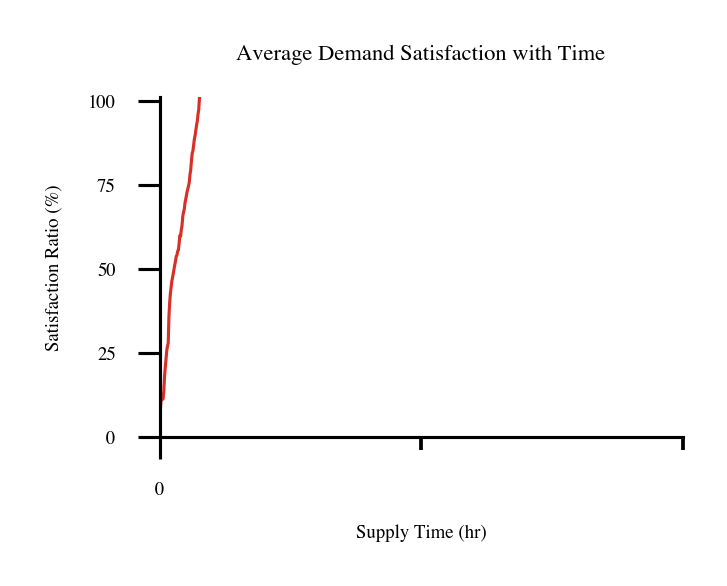

In [21]:
# Setting Universal Parameters for plotting: dots per inch (dpi), text font and size, label size
mpl.rcParams['figure.dpi'] = 450
font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 3}
mpl.rc('font', **font)
mpl.rc('xtick', labelsize=3)
mpl.rcParams['axes.linewidth'] = 0.5

# Prepping an xaxis with hr format
supply_duration_hr=supply_duration/60
xaxis=[x/3600 for x in new_index]

fig, ax=plt.subplots()
# Change figure size (and aspect ratio) by adjusting height and width here
fig.set_figwidth(1.5)
fig.set_figheight(1)

# Formatting Plot: Setting a Title, x- and y-axis limits, major and minor ticks
ax.set_title('Average Demand Satisfaction with Time')
ax.set_xlim(0,supply_duration_hr)
ax.set_ylim(0,101)
ax.set_xticks(np.arange(0,supply_duration_hr+1,4))
ax.set_xticks(np.arange(0,supply_duration_hr+1,1),minor=True)
ax.set_yticks(np.arange(0,101,25))
ax.tick_params(width=0.5)

# Data to be plotted: Mean as a percentage (hence the multiplication by 100)
# Change color by changing the string next to c= and linewidth by value
line1,=ax.plot(xaxis,mean, c='#d73027',linewidth=0.5)
plt.xlabel('Supply Time (hr)')
plt.ylabel('Satisfaction Ratio (%)')
# Optional: show grid or turn on and off spines (Plot box sides)
# ax.grid(visible=True,which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show

### Plotting the Distribution between Consumers (Equality)
Low Percentile, Median and High Percentile are plotted together to show the distribution between consumers with time. Area between Low and High Percentiles will be shaded

<function matplotlib.pyplot.show(close=None, block=None)>

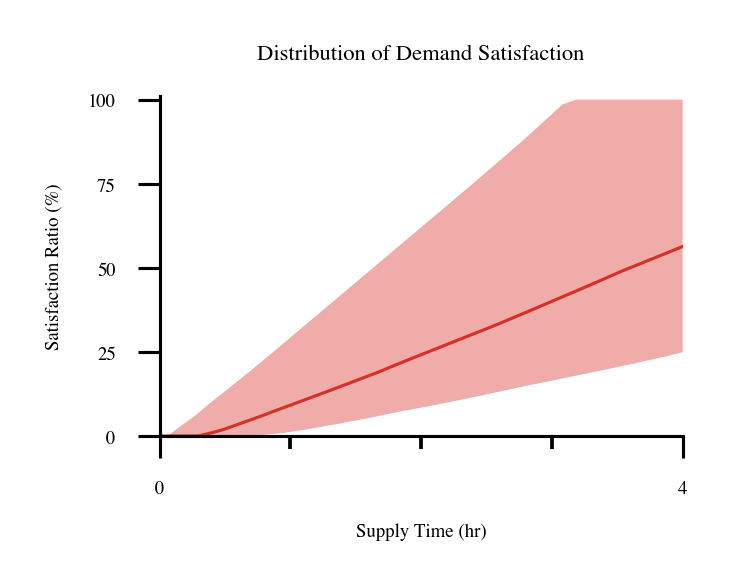

In [175]:
fig, ax=plt.subplots()
# Change figure size (and aspect ratio) by adjusting height and width here
fig.set_figwidth(1.5)
fig.set_figheight(1)

# Formatting Plot: Setting a Title, x- and y-axis limits, major and minor ticks
ax.set_title('Distribution of Demand Satisfaction')
ax.set_xlim(0,supply_duration_hr)
ax.set_ylim(0,101)
ax.set_xticks(np.arange(0,supply_duration_hr+1,4))
ax.set_xticks(np.arange(0,supply_duration_hr+1,1),minor=True)
ax.set_yticks(np.arange(0,101,25))
ax.tick_params(width=0.5)


# Data to be plotted: Mean as a percentage (hence the multiplication by 100)
# Change color by changing the string next to c= and linewidth by value
line1,=ax.plot(xaxis,median, c='#d73027',linewidth=0.5)
plt.fill_between(xaxis, y1=low_percentile, y2=high_percentile, alpha=0.4, color='#d73027', edgecolor=None)
plt.xlabel('Supply Time (hr)')
plt.ylabel('Satisfaction Ratio (%)')
# Optional: show grid or turn on and off spines (Plot box sides)
# ax.grid(visible=True,which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show